In [1]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob
import time

import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
# import pyproj # for converting proj4string
import shapely
# import shapefile
import geopandas as gpd
from osgeo import gdal
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
import flopy 

# from importlib import reload
# importlib.reload
# reload(flopy)

In [40]:
cvhm_dir = "C:/WRDAPP/GWFlowModel/CVHM2"
loadpth = cvhm_dir+ "/CVHM_archive_input/CentralValleyModelFiles_PP-1766_Input"
model_in = "/input"
model_ws = loadpth + model_in

In [56]:
# model_ws = join(loadpth,'parallel_oneto_denier','realization000')
load_only = ['DIS','LPF','OC', 'ZONE', 'MULT', 'BAS6']
m = flopy.modflow.Modflow.load('NAME.txt', model_ws= model_ws, 
                                exe_name='mf2k_fmp3_64_new.exe', version='mfnwt',
                              load_only=load_only,
                              )


In [26]:
m.dis.lenuni # units are meters and days

4

In [73]:
# 1600 m is 8 times the grid cell size (DELR), would need to interpolate rates potentially
db_files = pd.Series(os.listdir(cvhm_dir+'/CVHM_database'))
def load_shp(name):
    f = db_files[db_files.str.contains(name+'.zip')].values[0]
    grid = gpd.read_file(join(cvhm_dir,'CVHM_database', f))
    return(grid)

dis_grid = load_shp('DIS')


In [77]:
# mult_grid = load_shp('MULT') # doesn't have much to show
zone_grid = load_shp('ZONE') # doesn't have much

In [162]:
zone_grid.ROW.max(), zone_grid.COLUMN_.max() # y, x

(441, 98)

<AxesSubplot: >

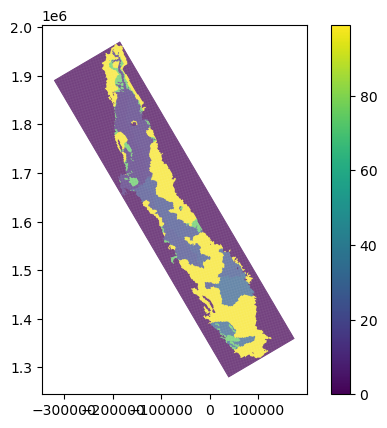

In [81]:
zone_grid.plot('l2zoneqpc',legend=True)

In [127]:
# run twice to download
grid_r = gpd.read_file(join(gwfm_dir, 'DIS_data/grid/grid.shp'))
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_r.unary_union], crs=grid_r.crs)
m_edge = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_r.unary_union.boundary], crs=grid_r.crs)

In [222]:
nrow = grid_r.row.max()
ncol = grid_r.column.max()

<AxesSubplot: >

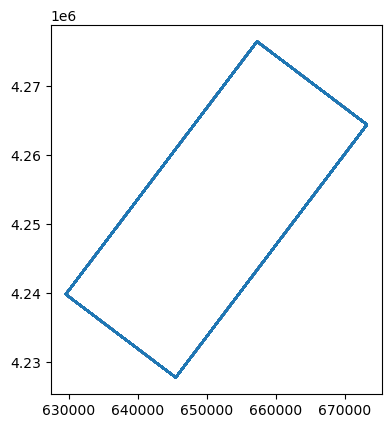

In [128]:
edge = gpd.sjoin(m_edge, zone_grid.to_crs(m_edge.crs), )
edge.plot()

In [129]:
# zone_r = gpd.sjoin(grid_r.to_crs(zone_grid.crs), zone_grid)
# zone_r = gpd.sjoin(grid_r, zone_grid.to_crs(grid_r.crs))

In [119]:
# Per CVHM release (https://www.sciencebase.gov/catalog/item/61e752abd34e3618e01cf6c7)
# Start Date: 1961-04-01, End Date: 2019-10-01
m.dis.nper/12, # 42.5 would be a model ending in 2003 which is the old CVHM, maybe I downloaded just the old files


42.5

In [130]:
# zone_r.plot('l1zoneqpc')
# zone_r.plot('CELLNUM')

In [39]:
# plt.imshow(m.lpf.hk.array[1,:,:])
# plt.colorbar()

In [10]:
cbb = flopy.utils.CellBudgetFile(model_ws+'/cbcf.out')



In [156]:
# hdobj = flopy.utils.HeadFile(model_ws+'/fort.375')


In [11]:
# returns list (shape of NSTPS by OC) of grid arrays
fright_all = np.asarray(cbb.get_data(text="FLOW RIGHT FACE"))
ffront_all = np.asarray(cbb.get_data(text="FLOW FRONT FACE"))
flower_all = np.asarray(cbb.get_data(text="FLOW LOWER FACE"))


In [181]:
# fright_all.shape

In [177]:
# load top and bottom and clean up to node by averaging
bnd_top = zone_r[zone_r.row==1]
# bnd_top = bnd_top.groupby('column').mean(numeric_only=True)
bnd_bot = zone_r[zone_r.row==100]
# bnd_bot = bnd_bot.groupby('column').mean(numeric_only=True)

# bnd.row, bnd.column

In [276]:
strt_date = pd.to_datetime('1961-04-01')
end_date = pd.to_datetime('2003-10-1')
# def month_diff(a, b):
#     return 12 * (a.dt.year - b.dt.year) + (a.dt.month - b.dt.month)
# month_diff(plt_date,  strt_date)

months = pd.date_range(strt_date, end_date, freq='MS')



In [280]:
# t = (1, int(40.5*12)) # a
# t = (1, int(40.5*12))

plt_date = pd.to_datetime('2000-10-01')

t = (1, np.where(months== plt_date)[0])

In [281]:
frf = cbb.get_data(text="FLOW RIGHT FACE", kstpkper= t)[0]
fff = cbb.get_data(text="FLOW FRONT FACE", kstpkper= t)[0]
flf = cbb.get_data(text="FLOW LOWER FACE", kstpkper= t)[0]

# net flow in a cell
# positivey is north, positive z is upward, positive x is
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    (frf, fff, flf), m
)  # no head array for volumetric discharge


-0.032926176


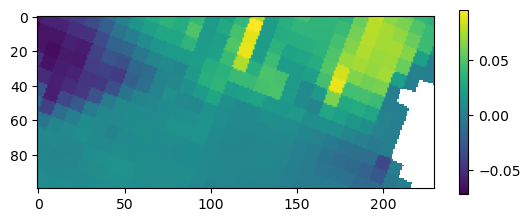

In [287]:
# for our model domain region, it reports that there is no flow in layers 1-3 for certain periods
vec_r = np.zeros((nrow,ncol))
vec_r[zone_r.row-1, zone_r.column-1] = qy[2, zone_r.ROW-1, zone_r.COLUMN_-1]
print(np.nanmean(qx[2, zone_r.ROW-1, zone_r.COLUMN_-1]))
plt.imshow(vec_r)
plt.colorbar(shrink=0.5)
# looking at qx, we generally see specific discharge positive which should align with flow
# generally from the foothills (east) to the delta (west), there are spots of local flow reversal that
# align with the middle of the cosumnes river (where dischrage is to the foothills)

# looking at qy

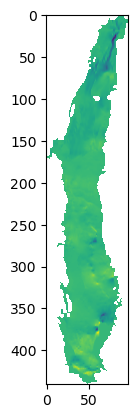

In [216]:
# plt.imshow(np.nanmean(qy, axis=0))
# layer 1 generally has no flow
plt.imshow(qy[2])

In [297]:
delc = m.dis.delc.array[0]
delr = m.dis.delr.array[0]
delr

1609.33

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlims'

(65982.52819824219, 115871.7568359375)

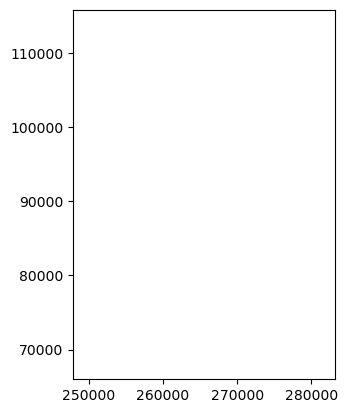

In [313]:
mapview = flopy.plot.PlotMapView(model=m)
# quadmesh = mapview.plot_ibound()
# quadmesh = mapview.plot_array(head, alpha=0.5)
k = 2
quiver = mapview.plot_vector(qx[k], qy[k], masked_values=[np.nan])

plt.xlim(zone_r.ROW.min()*delc, zone_r.ROW.max()*delc)
plt.ylim( zone_r.COLUMN_.min()*delr, zone_r.COLUMN_.max()*delr)
# linecollection = mapview.plot_grid()

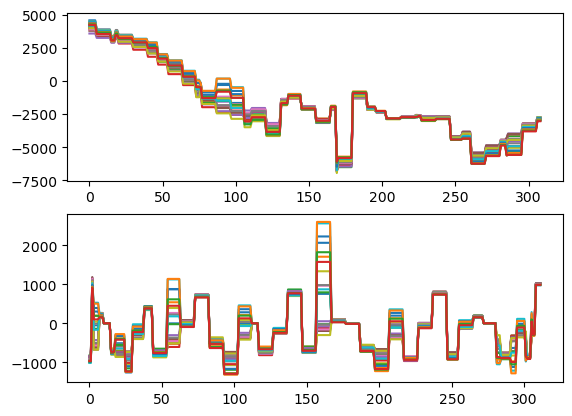

In [178]:
# layers 1-3 are the ones representing the alluvium
# need to double check which face to use
# generally I think it should be the front face which is in the north south direction I believe
fig, ax = plt.subplots(2,1)
# for t in np.arange(0, m.dis.nper):
for t in np.arange(int(40.5*12), m.dis.nper):
    xs = ffront_all[t, 2, bnd_top.ROW-1, bnd_top.COLUMN_-1]
    ax[0].plot(xs)
    xs = ffront_all[t, 2, bnd_bot.ROW-1, bnd_bot.COLUMN_-1]
    ax[1].plot(xs)


It's not entirely clear how to load the head output data which is important to check the regional flow direction makes sense. I could use these head fluxes but I don't know if they are even in the right direction. It sort of makes sense that the magnitude doesn't vary too much but I'm not sure how to interpret the variability along the cross-section. I would expect more in the pumping depressions but that doesn't seem to be the case. 

Also it seems potentially reasonable to assume 2003 values are not so different if historic contours are similar to current conditions.

In [171]:
out_dir = join(cvhm_dir, 'CVHM_archive_output/CentralValleyModelFiles_PP-1766_Output')
# not sure what this relates to

# pd.read_csv(join(out_dir,'headsout.txt'))

2    1   3.000000E+01   3.000000E+01             HEAD    98   441     1 (15(1X  \
0         -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    
1         -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    
2         -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    
3         -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    
4         -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    
...                                                   ...                                    
432314    -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    
432315    -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    
432316    -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    
432317    -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    
432318    -9999.0  -9999.0  -9999.0  -9999.0  -9999.0 ...                                    

       F8.1))         
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
432314           NaN  
432315           NaN  
432316           NaN  
432317           NaN  
432318           NaN  

[432319 rows x 2 columns]